# HW4

Overall rules:

- Do not split your answers into separate files. All answers must be in a single jupyter notebook.
- Obtain all required remote data using the appropriate API unless otherwise is specified.
- Refrain from using code comments to explain what has been done. Document your steps by writing appropriate markdown cells in your notebook.
- Avoid duplicating code by copying and pasting it from one cell to another. If copying and pasting is necessary, develop a suitable function for the task at hand and call that function.
- When providing parameters to a function, never use global variables. Instead, always pass parameters explicitly and always make use of local variables.
- Document your use of LLM models (ChatGPT, Claude, Code Pilot etc). Either take screenshots of your steps and include them with this notebook, or give me a full log (both questions and answers) in a markdown file named HW4-LLM-LOG.md.

Failure to adhere to these guidelines will result in a 15-point deduction for each infraction.

## Q1

In this problem, you will compare the performance of several supervised learning models on the CIFAR-10 dataset available through `tensorflow_datasets`. The CIFAR-10 dataset consists of 60,000 $32 \times 32$ color images in 10 classes, with 6,000 images per class. To simplify the computational requirements and focus on core algorithmic aspects, you may preprocess the images by converting them to grayscale.

1. Load the CIFAR-10 dataset using the `tensorflow_datasets` library. Preprocess the dataset by:
   - Converting the images to grayscale,
   - Flattening the image into a vector (if necessary) for models that require vector inputs,
   - Normalizing pixel values to the $[0,1]$ range.

2. Train and evaluate the following models on the dataset:
   - **Logistic Regression** (one-vs-rest and one-vs-one),
   - **Support Vector Machine (SVM)** with:
     - A linear kernel,
     - A Gaussian (RBF) kernel,
     - A polynomial kernel,
   - **A simple neural network** consisting of:
     - One or two hidden layers,
     - Nonlinear activation functions (such as ReLU or tanh),
     - A softmax output layer for classification.

3. For each model, report:
   - The overall test set classification accuracy,
   - The confusion matrix,
   - Precision, recall, and F1-score per class.

4. Conduct a **statistical error analysis**:
   - Compute $95\%$ confidence intervals for the test set accuracy estimates (e.g., using the binomial proportion confidence interval),
   - Discuss any significant differences between model performances.

5. Discuss the **computational trade-offs**:
   - Measure and report the **training time** and **inference time** for each model (e.g., using simple timing functions),
   - Measure and report **memory usage** where feasible (e.g., by estimating the number of parameters or using profiling tools),
   - Reflect on how model complexity (both in terms of runtime and memory) correlates with performance.

6. Conclude by discussing the observed trade-offs between **model simplicity**, **computational cost**, and **predictive accuracy**.

You may use `tensorflow`, `pytorch` or `keras` for neural network model implementation. Clearly indicate any hyperparameter choices (e.g., regularization strength, kernel parameters, number of neurons in hidden layers). Ensure that your experimental code supports reproducibility (by fixing random seeds where applicable).


In [ ]:
import tensorflow_datasets as tfds
import tensorflow as tf
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier, OneVsOneClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_recall_fscore_support, precision_score, recall_score, f1_score
from sklearn.svm import SVC
from medmnist import PneumoniaMNIST
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
import time
import random
import os
import matplotlib.pyplot as plt
import joblib
import pandas as pd
import re
from sklearn.feature_extraction.text import CountVectorizer
from tensorflow.keras import layers, regularizers, models
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Model
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from itertools import product
from medmnist import PneumoniaMNIST
from sklearn.model_selection import StratifiedKFold


In [ ]:
seed = 42
np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)

ds_train, ds_test = tfds.load('cifar10', split=['train', 'test'], as_supervised=True)

def preprocess(image, label):
    image = tf.image.rgb_to_grayscale(image)
    image = tf.cast(image, tf.float32) / 255.0
    image = tf.reshape(image, [-1])
    return image, label

ds_train = ds_train.map(preprocess).batch(50000)
ds_test = ds_test.map(preprocess).batch(10000)

for images, labels in ds_train.take(1):
    X_train_full = images.numpy()
    y_train_full = labels.numpy()

for images, labels in ds_test.take(1):
    X_test = images.numpy()
    y_test = labels.numpy()

X_train, _, y_train, _ = train_test_split(X_train_full, y_train_full, train_size=20000, random_state=seed, stratify=y_train_full)

print(f"✅ Eğitim verisi boyutu: {X_train.shape}")
print(f"✅ Test verisi boyutu  : {X_test.shape}")


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/cifar10/incomplete.HBRPOI_3.0.2/cifar10-train.tfrecord*...:   0%|         …

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/cifar10/incomplete.HBRPOI_3.0.2/cifar10-test.tfrecord*...:   0%|          …

Dataset cifar10 downloaded and prepared to /root/tensorflow_datasets/cifar10/3.0.2. Subsequent calls will reuse this data.
✅ Eğitim verisi boyutu: (20000, 1024)
✅ Test verisi boyutu  : (10000, 1024)


In [ ]:
def compute_confidence_interval(accuracy, n, confidence=0.95):
    z = 1.96
    se = np.sqrt((accuracy * (1 - accuracy)) / n)
    lower = accuracy - z * se
    upper = accuracy + z * se
    return max(0, lower), min(1, upper)


In [ ]:
def count_logreg_params(model, model_type="ovr"):
    total_params = 0
    for estimator in model.estimators_:
        total_params += np.prod(estimator.coef_.shape)
        total_params += np.prod(estimator.intercept_.shape)
    print(f"🔢 {model_type.upper()} toplam parametre sayısı: {total_params}")
    return total_params


In [ ]:
def evaluate_model(name, y_true, y_pred, train_time, test_time):
    acc = accuracy_score(y_true, y_pred)
    lower, upper = compute_confidence_interval(acc, len(y_true))

    print(f"\n📊 {name} Model Sonuçları")
    print(f"🧠 Eğitim süresi: {train_time:.2f} sn")
    print(f"⚡ Test süresi: {test_time:.2f} sn")
    print(f"🎯 Accuracy: {acc:.4f}")
    print(f"🔒 %95 Güven Aralığı: [{lower:.4f}, {upper:.4f}]")
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, digits=4))
    print("\nConfusion Matrix:")
    print(confusion_matrix(y_true, y_pred))

In [ ]:
base_lr = LogisticRegression(solver='saga', max_iter=1000, random_state=seed, n_jobs=-1)

ovr_model = OneVsRestClassifier(base_lr)
start_time = time.time()
ovr_model.fit(X_train, y_train)
ovr_train_time = time.time() - start_time

start_time = time.time()
y_pred_ovr = ovr_model.predict(X_test)
ovr_test_time = time.time() - start_time

num_params_ovr = count_logreg_params(ovr_model, model_type="ovr")

evaluate_model("One-vs-Rest", y_test, y_pred_ovr, ovr_train_time, ovr_test_time)

ovo_model = OneVsOneClassifier(base_lr)
start_time = time.time()
ovo_model.fit(X_train, y_train)
ovo_train_time = time.time() - start_time

start_time = time.time()
y_pred_ovo = ovo_model.predict(X_test)
ovo_test_time = time.time() - start_time

num_params_ovo = count_logreg_params(ovo_model, model_type="ovo")

evaluate_model("One-vs-One", y_test, y_pred_ovo, ovo_train_time, ovo_test_time)


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which 

🔢 OVR toplam parametre sayısı: 10250

📊 One-vs-Rest Model Sonuçları
🧠 Eğitim süresi: 3643.50 sn
⚡ Test süresi: 0.07 sn
🎯 Accuracy: 0.2594
🔒 %95 Güven Aralığı: [0.2508, 0.2680]

Classification Report:
              precision    recall  f1-score   support

           0     0.2819    0.2780    0.2800      1000
           1     0.3208    0.3330    0.3268      1000
           2     0.2164    0.1790    0.1959      1000
           3     0.1753    0.1390    0.1550      1000
           4     0.2037    0.1850    0.1939      1000
           5     0.2423    0.2590    0.2504      1000
           6     0.2199    0.2170    0.2184      1000
           7     0.2396    0.2310    0.2352      1000
           8     0.3056    0.3670    0.3335      1000
           9     0.3309    0.4060    0.3646      1000

    accuracy                         0.2594     10000
   macro avg     0.2536    0.2594    0.2554     10000
weighted avg     0.2536    0.2594    0.2554     10000


Confusion Matrix:
[[278  52  82  49  71 

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which 

🔢 OVO toplam parametre sayısı: 46125

📊 One-vs-One Model Sonuçları
🧠 Eğitim süresi: 3260.95 sn
⚡ Test süresi: 0.64 sn
🎯 Accuracy: 0.2620
🔒 %95 Güven Aralığı: [0.2534, 0.2706]

Classification Report:
              precision    recall  f1-score   support

           0     0.2827    0.2790    0.2808      1000
           1     0.3173    0.3240    0.3206      1000
           2     0.2040    0.1740    0.1878      1000
           3     0.1716    0.1390    0.1536      1000
           4     0.1951    0.1820    0.1883      1000
           5     0.2226    0.2420    0.2319      1000
           6     0.2462    0.2420    0.2441      1000
           7     0.2481    0.2280    0.2376      1000
           8     0.3164    0.3980    0.3525      1000
           9     0.3586    0.4120    0.3834      1000

    accuracy                         0.2620     10000
   macro avg     0.2563    0.2620    0.2581     10000
weighted avg     0.2563    0.2620    0.2581     10000


Confusion Matrix:
[[279  47  84  56  82  

In [ ]:
def count_svm_params(svm_model, input_dim):
    n_support_vectors = svm_model.support_vectors_.shape[0]
    param_count = n_support_vectors * input_dim + 1
    print(f"🔢 SVM ({svm_model.kernel}) tahmini parametre sayısı: {param_count}")
    return param_count

In [ ]:
def train_and_evaluate_svm(kernel_type, degree=None, gamma='scale'):
    print(f"\n🔍 SVM ({kernel_type}) modeli eğitiliyor...")

    if kernel_type == 'poly':
        model = SVC(kernel=kernel_type, degree=degree, gamma=gamma, random_state=seed)
    else:
        model = SVC(kernel=kernel_type, gamma=gamma, random_state=seed)

    start_train = time.time()
    model.fit(X_train, y_train)
    train_time = time.time() - start_train

    start_test = time.time()
    y_pred = model.predict(X_test)
    test_time = time.time() - start_test

    param_count = count_svm_params(model, input_dim=1024)

    evaluate_model(f"SVM ({kernel_type})", y_test, y_pred, train_time, test_time)

    print(f"\nToplam Parametre Sayısı: {param_count}")


In [ ]:
train_and_evaluate_svm(kernel_type='linear')

train_and_evaluate_svm(kernel_type='rbf')

train_and_evaluate_svm(kernel_type='poly', degree=3)



🔍 SVM (linear) modeli eğitiliyor...
🔢 SVM (linear) tahmini parametre sayısı: 19631105

📊 SVM (linear) Model Sonuçları
🧠 Eğitim süresi: 405.09 sn
⚡ Test süresi: 128.78 sn
🎯 Accuracy: 0.2520
🔒 %95 Güven Aralığı: [0.2435, 0.2605]

Classification Report:
              precision    recall  f1-score   support

           0     0.2452    0.2960    0.2682      1000
           1     0.2957    0.3300    0.3119      1000
           2     0.1876    0.2000    0.1936      1000
           3     0.1614    0.1520    0.1565      1000
           4     0.1924    0.1920    0.1922      1000
           5     0.2325    0.2260    0.2292      1000
           6     0.2276    0.1980    0.2118      1000
           7     0.2655    0.2050    0.2314      1000
           8     0.3262    0.3530    0.3391      1000
           9     0.3774    0.3680    0.3727      1000

    accuracy                         0.2520     10000
   macro avg     0.2512    0.2520    0.2507     10000
weighted avg     0.2512    0.2520    0.2507 

In [ ]:
def create_nn_model(input_dim=1024, hidden_units=[256, 128], activation='relu', dropout_rate=0.3):
    model = Sequential()
    model.add(Dense(hidden_units[0], input_dim=input_dim, activation=activation))
    model.add(Dropout(dropout_rate))
    if len(hidden_units) > 1:
        model.add(Dense(hidden_units[1], activation=activation))
        model.add(Dropout(dropout_rate))
    model.add(Dense(10, activation='softmax'))
    return model

In [ ]:
model = create_nn_model()

model.compile(optimizer=Adam(),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

start_train = time.time()
history = model.fit(X_train, y_train,
                    epochs=15,
                    batch_size=128,
                    validation_split=0.1,
                    verbose=1)
train_time = time.time() - start_train

start_test = time.time()
y_pred_probs = model.predict(X_test, verbose=0)
y_pred_nn = np.argmax(y_pred_probs, axis=1)
test_time = time.time() - start_test

evaluate_model("Neural Network", y_test, y_pred_nn, train_time, test_time)

print(f"\nToplam Parametre Sayısı: {model.count_params()}")


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/15
141/141 ━━━━━━━━━━━━━━━━━━━━ 11s 53ms/step - accuracy: 0.1466 - loss: 2.2888 - val_accuracy: 0.2280 - val_loss: 2.1083
Epoch 2/15
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.2150 - loss: 2.1200 - val_accuracy: 0.2695 - val_loss: 2.0639
Epoch 3/15
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.2421 - loss: 2.0700 - val_accuracy: 0.2685 - val_loss: 2.0392
Epoch 4/15
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.2494 - loss: 2.0449 - val_accuracy: 0.2795 - val_loss: 2.0034
Epoch 5/15
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.2649 - loss: 2.0170 - val_accuracy: 0.2875 - val_loss: 1.9880
Epoch 6/15
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.2693 - loss: 2.0077 - val_accuracy: 0.2845 - val_loss: 1.9758
Epoch 7/15
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.2790 - loss: 1.9890 - val_accuracy: 0.2965 - val_loss: 1.9624
Epoch 8/15
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.2849 - loss: 1.9689 - val_accuracy: 

Bu soruda bize CIFAR-10 adında bir veri seti verilmiş ve her biri 32x32 boyutunda, 10 farklı sınıfa ait renkli görüntülerden oluşan bu veri setinde amaç, verilen görüntülerin hangi sınıfa ait olduğunu tahmin etmek.

Ben bu ödevde sırasıyla Logistic Regression (OVR ve OVO), farklı çekirdeklerle SVM (Linear, RBF, Polynomial) ve basit bir tam bağlantılı (dense) yapay sinir ağı kullandım. Tüm modellerin eğitim ve test süreçlerinde zaman, doğruluk, precision, recall, F1-score, karışıklık matrisi gibi metrikler açısından karşılaştırdım.

En yüksek doğruluk skoruna %41.41 ile SVM (RBF) modeli ulaştı. Onu %38.44 doğrulukla SVM (Polynomial) ve %33.6 doğrulukla Yapay Sinir Ağı izledi. Logistic Regression modelleri ve SVM (Linear), yaklaşık %25-26 civarında doğruluk vererek en düşük performansı gösterdi. Bu modeller özellikle veri setindeki sınıfları ayırmada çok zorluk yaşadı. Yani pek benim istediğim sonuçları verdiği söylenemez. Aslında genel olarak bütün modeller benim istediğim sonucu vermediler. Doğrulukları çok düşük çıktı.

OvR ve OvO arasında da ciddi bir fark elde edemedim. Daha önceki ödevlerimde ikisi de tamamen aynı çıkmıştı. Bu ödevde farklı sonuçlar elde ettim ancak yine de birbirlerine yakınlar ve başarısızlar.

Modelin performansını daha iyi değerlendirebilmek için bizden istendiği gibi %95 güven aralığı kullandık.
Bu güven aralığında da en başarılı sonucu [0.4044, 0.4238] ile SVM(RBF) modeli verdi. Benim yorumumca bu model sınıfları rastgele dağıtmadı bir tahmin yapmaya çalıştı ve ufak da olsa başarılı oldu. En azından diğerlerine göre.

OVR ve OVO gibi modellerde ise bu aralık [0.2508, 0.2680] civarında kaldı. Yani modelin tahmini, rastgele sınıflandırmadan çok az daha iyi ve genel olarak başarısız.

Ayrıca karışıklık matrislerinden de anlaşılabileceği gibi düşük performans gösteren modeller, genellikle sınıflar arası karışıklıkta yüksek hata payına sahip. Özellikle sınıflar arası benzerlikler bu modeller için büyük bir sorun oluşturmuş. Örneğin 2 ile 10, 4 ile 6, 5 ile 8. Bunun sebebinin de sınıfları incelediğimizde benzer özelliklere sahip olduğunu görebilmemiz olduğunu düşünüyorum. Mesela 4 numaralı sınıf cat, 6 numaralı sınıf dog. Bunlar görece benzer sınıflar olduğu için karışabilir.


Modellerin eğitim ve test süreleri arasında büyük farklılıklar gözlemlendi:

| Model                      | Eğitim Süresi (sn) | Test Süresi (sn) | Parametre Sayısı  |
|---------------------------|--------------------|------------------|--------------------|
| Logistic Regression (OVR) | 3643.5             | 0.07             | 10,250             |
| Logistic Regression (OVO) | 3260.9             | 0.64             | 46,125             |
| SVM (Linear)              | 405.1              | 128.8            | ~19.6 milyon       |
| SVM (RBF)                 | 220.0              | 206.9            | ~19.5 milyon       |
| SVM (Poly)                | 298.4              | 123.1            | ~18.7 milyon       |
| Neural Network            | 17.1               | 3.4              | 296,586            |



Bu tablo da bize gösteriyor ki Neural Network diğerlerine göre çok hızlı çalışmış. Çalışma süresi ve verdiği sonuç bakımından Logistic Regression modelinden bu problemde hiç memnun kalmadım.

Neural Network hem süresi hem verdiği süre bakımından benim için en iyi model gibi duruyor.

SVM modelleri özellikle test süresinde oldukça yavaş çalıştı. Parametre sayıları açısından ise SVM modelleri çok daha fazla belleğe ihtiyaç duymakta.

Başarı odaklıysam SVM modellerini seçerdim.
Denge istiyorsam da yani hem başarı hem süre Neural Network seçerdim.

## Q2

In this assignment, you will explore the application of boosting algorithms to a medical image classification problem. The dataset is **PneumoniaMNIST** from the **MedMNIST** collection, available through `tensorflow_datasets` under `medmnist.pneumoniamnist`. PneumoniaMNIST consists of chest X-ray images labeled either as **normal** or **pneumonia**.

The goal is to predict whether a patient shows signs of pneumonia based on their chest X-ray image.

1. Load the PneumoniaMNIST dataset using the `tensorflow_datasets` library. Preprocess the dataset by:
   - Normalizing the pixel values to $[0,1]$,
   - Flattening the $28\times28$ images into vectors suitable for tabular classifiers.

2. Train and evaluate the following models:
   - **Gradient Boosted Decision Trees (GBDT)** using **XGBoost**,
   - **AdaBoost** with **decision stumps** (single-level decision trees) as weak learners,
   - **Gradient Boosting Classifier** using **LightGBM** or **sklearn's GradientBoostingClassifier**.

3. For each model report the test set classification **accuracy**, **precision**, **recall**, **F1-score**, and do a proper error analysis on the values you calculated.

4. Interpret the learned models:
   - Extract and rank the most important pixels (features) contributing to the classification decision (feature importance analysis).
   - Visualize and interpret these "important pixels" on the original $28\times28$ image grid. Discuss whether they align with medical intuition (e.g., lung region emphasis).

5. Discuss computational aspects:
   - Measure and report the **training time** and **inference time** for each boosting model,
   - Report and compare the **model size** (e.g., number of leaves, total size of the trained model).

6. Write a final summary:
   - Summarize the strengths and weaknesses you observed for each boosting method in this specific small-image classification task,
   - Comment on whether boosting methods are well-suited for this type of structured low-dimensional image data compared to neural network approaches.

Hyperparameters such as learning rate, number of estimators, and maximum tree depth should be selected using 5-fold cross-validation or a separate validation split. Pay special attention to **early stopping** where appropriate to avoid overfitting.


In [ ]:
train_data = PneumoniaMNIST(split='train', download=True)
test_data = PneumoniaMNIST(split='test', download=True)

X_train = train_data.imgs.astype(np.float32) / 255.0
y_train = train_data.labels.flatten()

X_test = test_data.imgs.astype(np.float32) / 255.0
y_test = test_data.labels.flatten()

X_train = X_train.reshape(-1, 28*28)
X_test = X_test.reshape(-1, 28*28)

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape :", X_test.shape)
print("y_test shape :", y_test.shape)


100%|██████████| 4.17M/4.17M [00:05<00:00, 767kB/s]

X_train shape: (4708, 784)
y_train shape: (4708,)
X_test shape : (624, 784)
y_test shape : (624,)


In [ ]:
def generate_param_combinations(param_grid):
    keys, values = zip(*param_grid.items())
    for combination in product(*values):
        yield dict(zip(keys, combination))


In [ ]:
def manual_cv_boosting(X, y, model_cls, param_grid, apply_early_stopping=False):
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    best_f1 = 0
    best_params = None
    all_results = []
    total_start = time.time()

    print(f"📊 {model_cls.__name__} için 5-Fold CV başlatıldı...\n")

    for params in generate_param_combinations(param_grid):
        f1_scores = []
        print(f"🎯 Parametreler: {params}")

        for fold, (train_idx, val_idx) in enumerate(skf.split(X, y), 1):
            X_tr, X_val = X[train_idx], X[val_idx]
            y_tr, y_val = y[train_idx], y[val_idx]

            model = model_cls(**params)

            if apply_early_stopping and model_cls.__name__ == 'XGBClassifier':
                model.fit(
                    X_tr,
                    y_tr,
                    eval_set=[(X_val, y_val)],
                    eval_metric='logloss',
                    early_stopping_rounds=10,
                    verbose=False
                  )
            else:
                model.fit(X_tr, y_tr)

            y_pred = model.predict(X_val)
            f1 = f1_score(y_val, y_pred, zero_division=0)
            f1_scores.append(f1)
            print(f"  Fold {fold}: F1 = {f1:.4f}")

        mean_f1 = np.mean(f1_scores)
        print(f"  ➤ Ortalama F1-score: {mean_f1:.4f}\n")

        all_results.append((params, mean_f1))

        if mean_f1 > best_f1:
            best_f1 = mean_f1
            best_params = params

    elapsed = time.time() - total_start
    print(f"✅ En iyi parametreler: {best_params}")
    print(f"✅ En iyi ortalama F1-score: {best_f1:.4f}")
    print(f"🕒 Toplam süre: {elapsed:.2f} saniye\n")

    return best_params, best_f1


In [ ]:
xgb_param_grid = {
    'learning_rate': [0.05, 0.1],
    'n_estimators': [50, 100],
    'max_depth': [2, 3]
}

best_params_xgb, best_f1_xgb = manual_cv_boosting(
    X=X_train,
    y=y_train,
    model_cls=lambda **params: xgb.XGBClassifier(
        use_label_encoder=False, eval_metric='logloss', random_state=42, **params
    ),
    param_grid=xgb_param_grid,
    apply_early_stopping=True
)


📊 <lambda> için 5-Fold CV başlatıldı...

🎯 Parametreler: {'learning_rate': 0.05, 'n_estimators': 50, 'max_depth': 2}


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [17:43:04] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


  Fold 1: F1 = 0.9501


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [17:43:05] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


  Fold 2: F1 = 0.9524


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [17:43:05] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


  Fold 3: F1 = 0.9486


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [17:43:06] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


  Fold 4: F1 = 0.9473


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [17:43:06] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


  Fold 5: F1 = 0.9551
  ➤ Ortalama F1-score: 0.9507

🎯 Parametreler: {'learning_rate': 0.05, 'n_estimators': 50, 'max_depth': 3}


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [17:43:06] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


  Fold 1: F1 = 0.9619


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [17:43:07] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


  Fold 2: F1 = 0.9549


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [17:43:07] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


  Fold 3: F1 = 0.9560


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [17:43:08] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


  Fold 4: F1 = 0.9615


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [17:43:09] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


  Fold 5: F1 = 0.9582
  ➤ Ortalama F1-score: 0.9585

🎯 Parametreler: {'learning_rate': 0.05, 'n_estimators': 100, 'max_depth': 2}


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [17:43:09] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


  Fold 1: F1 = 0.9611


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [17:43:10] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


  Fold 2: F1 = 0.9571


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [17:43:11] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


  Fold 3: F1 = 0.9579


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [17:43:12] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


  Fold 4: F1 = 0.9592


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [17:43:13] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


  Fold 5: F1 = 0.9624
  ➤ Ortalama F1-score: 0.9595

🎯 Parametreler: {'learning_rate': 0.05, 'n_estimators': 100, 'max_depth': 3}


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [17:43:13] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


  Fold 1: F1 = 0.9681


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [17:43:14] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


  Fold 2: F1 = 0.9583


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [17:43:15] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


  Fold 3: F1 = 0.9620


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [17:43:17] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


  Fold 4: F1 = 0.9674


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [17:43:18] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


  Fold 5: F1 = 0.9722
  ➤ Ortalama F1-score: 0.9656

🎯 Parametreler: {'learning_rate': 0.1, 'n_estimators': 50, 'max_depth': 2}


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [17:43:19] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


  Fold 1: F1 = 0.9606


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [17:43:19] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


  Fold 2: F1 = 0.9585


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [17:43:20] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


  Fold 3: F1 = 0.9566


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [17:43:20] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


  Fold 4: F1 = 0.9606


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [17:43:20] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


  Fold 5: F1 = 0.9630
  ➤ Ortalama F1-score: 0.9599

🎯 Parametreler: {'learning_rate': 0.1, 'n_estimators': 50, 'max_depth': 3}


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [17:43:21] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


  Fold 1: F1 = 0.9674


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [17:43:21] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


  Fold 2: F1 = 0.9611


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [17:43:22] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


  Fold 3: F1 = 0.9632


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [17:43:22] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


  Fold 4: F1 = 0.9661


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [17:43:23] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


  Fold 5: F1 = 0.9692
  ➤ Ortalama F1-score: 0.9654

🎯 Parametreler: {'learning_rate': 0.1, 'n_estimators': 100, 'max_depth': 2}


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [17:43:24] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


  Fold 1: F1 = 0.9715


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [17:43:24] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


  Fold 2: F1 = 0.9611


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [17:43:25] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


  Fold 3: F1 = 0.9633


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [17:43:25] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


  Fold 4: F1 = 0.9653


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [17:43:26] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


  Fold 5: F1 = 0.9687
  ➤ Ortalama F1-score: 0.9660

🎯 Parametreler: {'learning_rate': 0.1, 'n_estimators': 100, 'max_depth': 3}


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [17:43:27] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


  Fold 1: F1 = 0.9744


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [17:43:28] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


  Fold 2: F1 = 0.9660


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [17:43:29] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


  Fold 3: F1 = 0.9724


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [17:43:30] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


  Fold 4: F1 = 0.9696


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [17:43:31] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


  Fold 5: F1 = 0.9757
  ➤ Ortalama F1-score: 0.9716

✅ En iyi parametreler: {'learning_rate': 0.1, 'n_estimators': 100, 'max_depth': 3}
✅ En iyi ortalama F1-score: 0.9716
🕒 Toplam süre: 28.48 saniye



In [ ]:
ada_param_grid = {
    'n_estimators': [50, 100],
    'learning_rate': [0.5, 1.0],
    'estimator': [DecisionTreeClassifier(max_depth=1)]
}

best_params_ada, best_f1_ada = manual_cv_boosting(
    X=X_train,
    y=y_train,
    model_cls=AdaBoostClassifier,
    param_grid=ada_param_grid,
    apply_early_stopping=False
)

📊 AdaBoostClassifier için 5-Fold CV başlatıldı...

🎯 Parametreler: {'n_estimators': 50, 'learning_rate': 0.5, 'estimator': DecisionTreeClassifier(max_depth=1)}
  Fold 1: F1 = 0.9555
  Fold 2: F1 = 0.9574
  Fold 3: F1 = 0.9526
  Fold 4: F1 = 0.9584
  Fold 5: F1 = 0.9567
  ➤ Ortalama F1-score: 0.9561

🎯 Parametreler: {'n_estimators': 50, 'learning_rate': 1.0, 'estimator': DecisionTreeClassifier(max_depth=1)}
  Fold 1: F1 = 0.9594
  Fold 2: F1 = 0.9612
  Fold 3: F1 = 0.9520
  Fold 4: F1 = 0.9618
  Fold 5: F1 = 0.9665
  ➤ Ortalama F1-score: 0.9602

🎯 Parametreler: {'n_estimators': 100, 'learning_rate': 0.5, 'estimator': DecisionTreeClassifier(max_depth=1)}
  Fold 1: F1 = 0.9616
  Fold 2: F1 = 0.9597
  Fold 3: F1 = 0.9577
  Fold 4: F1 = 0.9599
  Fold 5: F1 = 0.9587
  ➤ Ortalama F1-score: 0.9595

🎯 Parametreler: {'n_estimators': 100, 'learning_rate': 1.0, 'estimator': DecisionTreeClassifier(max_depth=1)}
  Fold 1: F1 = 0.9670
  Fold 2: F1 = 0.9666
  Fold 3: F1 = 0.9619
  Fold 4: F1 = 0.9616


In [ ]:
gb_param_grid = {
    'n_estimators': [50, 100],
    'learning_rate': [0.05, 0.1],
    'max_depth': [2, 3]
}

best_params_gb, best_f1_gb = manual_cv_boosting(
    X=X_train,
    y=y_train,
    model_cls=GradientBoostingClassifier,
    param_grid=gb_param_grid,
    apply_early_stopping=False
)

📊 GradientBoostingClassifier için 5-Fold CV başlatıldı...

🎯 Parametreler: {'n_estimators': 50, 'learning_rate': 0.05, 'max_depth': 2}
  Fold 1: F1 = 0.9524
  Fold 2: F1 = 0.9526
  Fold 3: F1 = 0.9434
  Fold 4: F1 = 0.9480
  Fold 5: F1 = 0.9539
  ➤ Ortalama F1-score: 0.9501

🎯 Parametreler: {'n_estimators': 50, 'learning_rate': 0.05, 'max_depth': 3}
  Fold 1: F1 = 0.9599
  Fold 2: F1 = 0.9587
  Fold 3: F1 = 0.9539
  Fold 4: F1 = 0.9561
  Fold 5: F1 = 0.9621
  ➤ Ortalama F1-score: 0.9581

🎯 Parametreler: {'n_estimators': 50, 'learning_rate': 0.1, 'max_depth': 2}
  Fold 1: F1 = 0.9626
  Fold 2: F1 = 0.9585
  Fold 3: F1 = 0.9554
  Fold 4: F1 = 0.9593
  Fold 5: F1 = 0.9634
  ➤ Ortalama F1-score: 0.9598

🎯 Parametreler: {'n_estimators': 50, 'learning_rate': 0.1, 'max_depth': 3}
  Fold 1: F1 = 0.9668
  Fold 2: F1 = 0.9619
  Fold 3: F1 = 0.9585
  Fold 4: F1 = 0.9647
  Fold 5: F1 = 0.9694
  ➤ Ortalama F1-score: 0.9643

🎯 Parametreler: {'n_estimators': 100, 'learning_rate': 0.05, 'max_depth': 2

In [ ]:
def evaluate_on_test(model, X_train, y_train, X_test, y_test):
    import time
    start_train = time.time()
    model.fit(X_train, y_train)
    train_time = time.time() - start_train

    start_test = time.time()
    y_pred = model.predict(X_test)
    test_time = time.time() - start_test

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, zero_division=0)
    rec = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)

    print(f"✅ Test Seti Performansı:")
    print(f"Accuracy : {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall   : {rec:.4f}")
    print(f"F1-Score : {f1:.4f}")
    print(f"🕒 Eğitim süresi: {train_time:.4f} s")
    print(f"⚡ Tahmin süresi: {test_time:.4f} s")

    return {
        "accuracy": acc,
        "precision": prec,
        "recall": rec,
        "f1": f1,
        "train_time": train_time,
        "test_time": test_time
    }


In [ ]:
xgb_final = xgb.XGBClassifier(
    **best_params_xgb,
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)

xgb_results = evaluate_on_test(xgb_final, X_train, y_train, X_test, y_test)


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [18:39:33] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


✅ Test Seti Performansı:
Accuracy : 0.8397
Precision: 0.8046
Recall   : 0.9821
F1-Score : 0.8845
🕒 Eğitim süresi: 1.0548 s
⚡ Tahmin süresi: 0.0020 s


In [ ]:
ada_final = AdaBoostClassifier(**best_params_ada, random_state=42)
ada_results = evaluate_on_test(ada_final, X_train, y_train, X_test, y_test)


gb_final = GradientBoostingClassifier(**best_params_gb, random_state=42)
gb_results = evaluate_on_test(gb_final, X_train, y_train, X_test, y_test)

✅ Test Seti Performansı:
Accuracy : 0.8189
Precision: 0.7856
Recall   : 0.9769
F1-Score : 0.8709
🕒 Eğitim süresi: 20.4288 s
⚡ Tahmin süresi: 0.0393 s
✅ Test Seti Performansı:
Accuracy : 0.8365
Precision: 0.8000
Recall   : 0.9846
F1-Score : 0.8828
🕒 Eğitim süresi: 60.2890 s
⚡ Tahmin süresi: 0.0027 s


In [ ]:
def plot_importance_heatmap(importances, title):
    heatmap = np.array(importances).reshape(28, 28)
    plt.figure(figsize=(5, 5))
    sns.heatmap(heatmap, cmap='Reds', cbar=True, square=True)
    plt.title(title)
    plt.axis('off')
    plt.show()


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128293 (\N{FIRE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


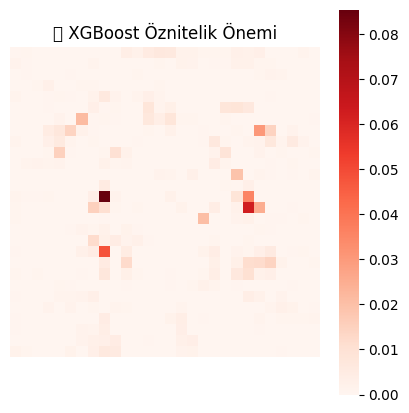

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128293 (\N{FIRE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


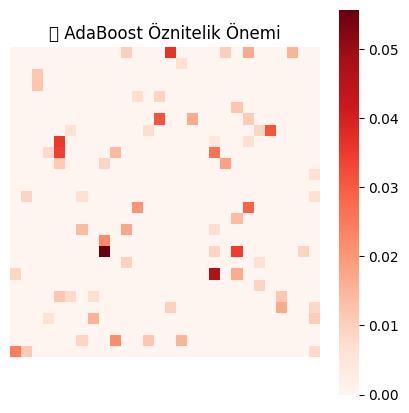

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128293 (\N{FIRE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


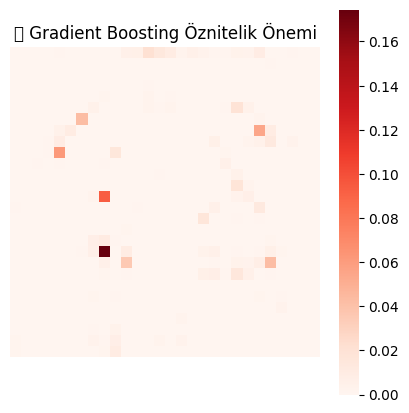

In [ ]:
plot_importance_heatmap(xgb_final.feature_importances_, "🔥 XGBoost Öznitelik Önemi")

plot_importance_heatmap(ada_final.feature_importances_, "🔥 AdaBoost Öznitelik Önemi")

plot_importance_heatmap(gb_final.feature_importances_, "🔥 Gradient Boosting Öznitelik Önemi")

In [ ]:
def save_and_get_model_size(model, filename):
    joblib.dump(model, filename)
    size_kb = os.path.getsize(filename) / 1024
    return round(size_kb, 2)

In [ ]:
xgb_model_size = save_and_get_model_size(xgb_final, "xgb_model.pkl")
xgb_n_trees = xgb_final.n_estimators

print(f"XGBoost → Ağaç sayısı: {xgb_n_trees}, Model boyutu: {xgb_model_size} KB")

ada_model_size = save_and_get_model_size(ada_final, "ada_model.pkl")
ada_n_trees = len(ada_final.estimators_)

print(f"AdaBoost → Ağaç sayısı: {ada_n_trees}, Model boyutu: {ada_model_size} KB")

gb_model_size = save_and_get_model_size(gb_final, "gb_model.pkl")
gb_n_trees = len(gb_final.estimators_)

print(f"GradientBoosting → Ağaç sayısı: {gb_n_trees}, Model boyutu: {gb_model_size} KB")

XGBoost → Ağaç sayısı: 100, Model boyutu: 116.82 KB
AdaBoost → Ağaç sayısı: 100, Model boyutu: 65.44 KB
GradientBoosting → Ağaç sayısı: 100, Model boyutu: 188.63 KB


Bu soruda bize PneumoniaMNIST adlı bir tıbbi görüntü veri seti verilmiş ve bu veri setinde yer alan göğüs röntgeni görüntüleri üzerinden bir hastada zatürre (pneumonia) olup olmadığını sınıflandırmamız istenmiş. Görüntüler 28x28 boyutunda olup etiketler ikili sınıflandırma problemi olarak tanımlanmıştır: normal ve pneumonia.

Modelleme aşamasında boosting temelli üç farklı algoritma kullandım: XGBoost, AdaBoost ve Gradient Boosting. Modellerin hiperparametrelerini de 5-fold çapraz doğrulama yaparak en iyi F1-score’a göre seçtim.

### 🔍 Performans Analizi

| Model             | Accuracy | Precision | Recall  | F1-Score | Eğitim Süresi (sn) | Test Süresi (sn) |
|-------------------|----------|-----------|---------|----------|---------------------|------------------|
| **XGBoost**        | 0.8397   | 0.8046    | 0.9821  | 0.8845   | 1.05                | 0.002            |
| **AdaBoost**       | 0.8189   | 0.7856    | 0.9769  | 0.8709   | 20.43               | 0.039            |
| **GradientBoosting** | 0.8365 | 0.8000    | 0.9846  | 0.8828   | 60.29               | 0.003            |

---



Bu tabloya bakıldığında her üç model de oldukça yüksek F1-skorlarına ulaşmış oldum. Özellikle recall değerleri 0.97’nin üzerinde çıkmıştır; bu da modellerin zatürre hastalarını doğru tespit etmede çok başarılı olduğunu gösteriyor. Ancak precision değerlerinin recall'a kıyasla daha düşük kalması, modellerin bazı sağlıklı bireyleri de bize yanlışlıkla hasta olarak sınıflandırdığını gösteriyor.


Modellerde genel olarak düşük precision ve yüksek recall değerleri çıktı.  Bu durum özellikle sağlıkla ilgili kritik uygulamalarda tercih edilebilir çünkü bence sağlık alanında önemli olan şey gerçek hastaları kaçırmamak. Sağlıklı kişilere hasta demek, gerçek hastaları kaçırmaktan çok daha iyi bir durum. Extra hasta çıkarmak sağlık giderlerimizi arttırsa da en azından ölüm vakalarını azaltmış oluruz.

Gradient Boosting modelinde recall en yüksek değere (0.9846) ulaşmışken, precision yine de %80 civarında kalmıştır. Bu durum, bu modelin özellikle benim istediğim gibi bir performans verdiğini göstermekte. AdaBoost modelinde precision ve recall dengesi en kötü sonuçları elde etmiştir.

Her üç modelin öznitelik önem haritaları incelendiğinde, yoğunlaşmaların göğüs merkezindeki ve alt-orta bölgelerde toplandığını görüyorum. Bu alanda da en başarılı modelin AdaBoost ya da XGBoost olduğunu düşünüyorum.

Ama genel olarak gösterdikleri bölgeleri beğendim çünkü akciğer bölgesini gösterdikleri kesin.


### ⏱️ Hesaplama Süresi ve Model Boyutu

| Model             | Ağaç Sayısı | Model Boyutu (KB) |
|-------------------|-------------|--------------------|
| **XGBoost**        | 100         | 116.82             |
| **AdaBoost**       | 100         | 65.44              |
| **GradientBoosting** | 100       | 188.63             |

Hesaplama süresi açısından XGBoost, eğitim süresinde açık ara en hızlı model olmuş gibi gözüküyor. Süreler kısa ama kat farkı olarak baktığımızda XGBoost en hızlısı oldu. AdaBoost orta seviyede hızlıyken Gradient Boosting çok daha uzun sürede tamamlandı. Benzer şekilde model boyutu olarak da en hafif model AdaBoost’tur, Gradient Boosting ise daha fazla belleğe ihtiyaç duydu.

Bu problemde boosting tabanlı modeller genel olarak başarılı sonuçlar verdi. Özellikle XGBoost, yüksek F1 değeri, düşük eğitim süresi ve nispeten küçük model boyutuyla dengeli bir seçim oldu. Gradient Boosting daha iyi recall değerine ulaşsa da, eğitim süresi ve model boyutu açısından maliyetli. AdaBoost, daha sade bir yapıya sahip olsa da diğer modellere göre biraz daha düşük performans gösterdi.

Benim tercihim ise Gradient Boosting'ten yana çünkü dediğim gibi önemli olanın hastaları kaçırmamak olduğunu düşünüyorum.

## Q3

In this question, you will investigate the use of **autoencoders** for compressing high-dimensional text data into a lower-dimensional latent space. You will use the **IMDB movie reviews dataset** from `tensorflow_datasets` and develop a pipeline based on **count vectorization**, followed by a **fully-connected autoencoder**.  This question focuses on **unsupervised representation learning** and reconstruction accuracy in the **bag-of-words (BoW)** paradigm.

#### **Part I: Preprocessing Pipeline**

1. Load the `imdb_reviews` dataset using `tensorflow_datasets`.
2. Construct a preprocessing pipeline consisting of the following steps:
   - **Text cleaning**: remove punctuation and convert all text to lowercase.
   - **Tokenization**: split the review into word tokens.
   - **Count-based vectorization**:
     - Use `sklearn.feature_extraction.text.CountVectorizer`,
     - Limit the vocabulary to the top $V = 5000$ most frequent words,
     - Represent each review as a **$V$-dimensional sparse count vector**.

3. Optionally, apply TF scaling or binary indicator (0/1) encoding to the count vectors. Justify your choice.

#### **Part II: Autoencoder Architecture**

4. Build a **fully-connected feedforward autoencoder** in TensorFlow/Keras:
   - The **input layer** accepts a $V$-dimensional BoW vector,
   - The **encoder** compresses it through one or more dense layers to a **latent space** of dimension $d \ll V$ (e.g., $d = 32$ or $64$),
   - The **decoder** maps the latent representation back to a $V$-dimensional output using symmetric architecture,
   - Use **sigmoid activation** on the final output layer to model per-word presence/absence (binary cross-entropy loss),
   - Apply **dropout** and/or **L2 regularization** to mitigate overfitting.

#### **Part III: Training and Evaluation**

5. Train the autoencoder on the training portion of the dataset using:
   - Mini-batch SGD or Adam optimizer,
   - Binary cross-entropy loss,
   - A held-out validation set for early stopping.

6. Evaluate the quality of the trained autoencoder on the test set:
   - For each reconstructed output $\hat{x}$ and corresponding input $x$, compute the **binary prediction** $\hat{x}_i = 1$ if $\hat{x}_i > 0.5$,
   - Compute **per-sample accuracy**: proportion of correctly reconstructed binary entries per BoW vector together with a proper error analysis,
   - Report the **mean accuracy** across all test samples together with a proper error analysis.

7. In addition, report:
   - The total number of parameters in the model,
   - The average compression ratio (input dimension / latent dimension),
   - A few example reconstructions: for 5 randomly chosen reviews, list the top-10 most frequent words in the original and reconstructed BoW vectors. Discuss any semantic degradation or preservation.

#### **Part IV: Latent Space Visualization and Interpretation**

8. Extract the **latent representations** of 1000 test reviews.
9. Use PCA to reduce the $d$-dimensional latent codes to 2D and visualize the resulting plot.
   - Color the points based on **sentiment label** (positive or negative, available in the dataset but not used during training),
   - Discuss whether the autoencoder latent space **implicitly clusters** sentences by sentiment, even though the model was trained in an unsupervised manner.


In [2]:
dataset, info = tfds.load('imdb_reviews', split=['train', 'test'], with_info=True, as_supervised=True)
train_data, test_data = dataset

def extract_texts_and_labels(data):
    texts, labels = [], []
    for text, label in tfds.as_numpy(data):
        texts.append(text.decode('utf-8'))
        labels.append(int(label))
    return texts, labels

train_texts, train_labels = extract_texts_and_labels(train_data)
test_texts, test_labels = extract_texts_and_labels(test_data)

def clean_text(text):
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)
    return text

train_texts = [clean_text(text) for text in train_texts]
test_texts = [clean_text(text) for text in test_texts]

vectorizer = CountVectorizer(max_features=5000, binary=True)
X_train = vectorizer.fit_transform(train_texts).toarray()
X_test = vectorizer.transform(test_texts).toarray()

input_dim = X_train.shape[1]
print(f"Giriş boyutu: {input_dim}")

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/incomplete.PUF025_1.0.0/imdb_reviews-train.tfrecor…

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/incomplete.PUF025_1.0.0/imdb_reviews-test.tfrecord…

Generating unsupervised examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/incomplete.PUF025_1.0.0/imdb_reviews-unsupervised.…

Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.
Giriş boyutu: 5000


Sayı vektörleri, kelimelerin bir belgede kaç kez geçtiğini temsil eder.

TF Ölçeklendirme (Term Frequency):
Bir kelimenin bir belgedeki frekansını doğrudan kullanmak, daha sık geçen kelimelere daha fazla önem vermesine olanak tanır. Bu, belgenin içeriği hakkında önemli bilgiler taşıyan kelimelerin daha iyi temsil edilmesine yardımcı olabilir. Ancak, çok sık geçen ancak ayırt edici olmayan kelimelerin (örneğin, "the", "a", "is") etkisi artabilir.

İkili Gösterge:
Bir kelimenin belgede bulunup bulunmadığını gösterir. Bu yaklaşım, kelime frekans bilgisini kaybeder ancak kelime varlığına veya yokluğuna odaklanmasını sağlar. Bu, özellikle belgenin ana temasını belirleyen kelimelerin öğrenilmesi açısından faydalı olabilir.

Bu örnekte, ikili gösterge kodlamasını uygulamak tercih edilebilir. Bunun nedeni, hangi kelimelerin bir incelemede bulunduğunu yeniden yapılandırmaktır. Kelime frekansları önemli olsa da, ilk aşamada kelime varlığına odaklanmak, modelin temel sözcüksel yapıyı öğrenmesine yardımcı olabilir.

In [14]:
latent_dim = 64
dropout_rate = 0.2
l2_reg = 1e-5

def build_autoencoder(input_dim, latent_dim, dropout_rate, l2_reg):
    input_layer = layers.Input(shape=(input_dim,))

    encoded = layers.Dense(1024, activation='relu', kernel_regularizer=regularizers.l2(l2_reg))(input_layer)
    encoded = layers.Dropout(dropout_rate)(encoded)
    encoded = layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(l2_reg))(encoded)
    encoded = layers.Dense(latent_dim, activation='relu', name='latent_vector')(encoded)

    decoded = layers.Dense(256, activation='relu')(encoded)
    decoded = layers.Dense(1024, activation='relu')(decoded)
    output_layer = layers.Dense(input_dim, activation='sigmoid')(decoded)

    autoencoder = models.Model(inputs=input_layer, outputs=output_layer)
    return autoencoder

autoencoder = build_autoencoder(input_dim=5000, latent_dim=latent_dim,
                                 dropout_rate=dropout_rate, l2_reg=l2_reg)

autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

autoencoder.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 5000)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1024)           │     5,121,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 256)            │       262,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ latent_vector (Dense)           │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 256)            │        16,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 1024)           │       263,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 5000)           │     5,125,000 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,804,680 (41.22 MB)

 Trainable params: 10,804,680 (41.22 MB)

 Non-trainable params: 0 (0.00 B)

In [4]:
X_tr, X_val = train_test_split(X_train, test_size=0.1, random_state=42)

early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = autoencoder.fit(
    X_tr, X_tr,
    epochs=50,
    batch_size=256,
    shuffle=True,
    validation_data=(X_val, X_val),
    callbacks=[early_stop],
    verbose=1
)


Epoch 1/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 46s 352ms/step - loss: 0.2562 - val_loss: 0.0864
Epoch 2/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0842 - val_loss: 0.0803
Epoch 3/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0794 - val_loss: 0.0779
Epoch 4/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0777 - val_loss: 0.0770
Epoch 5/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0760 - val_loss: 0.0756
Epoch 6/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0751 - val_loss: 0.0751
Epoch 7/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0746 - val_loss: 0.0748
Epoch 8/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0743 - val_loss: 0.0744
Epoch 9/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0739 - val_loss: 0.0737
Epoch 10/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0732 - val_loss: 0.0730
Epoch 11/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0722 - val_loss: 0.0724
Epoch 12/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0

In [5]:
reconstructed = autoencoder.predict(X_test)

reconstructed_binary = (reconstructed > 0.5).astype(int)


782/782 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step


In [6]:
def compute_sample_accuracy(original, reconstructed):
    return np.mean(original == reconstructed, axis=1)

sample_accuracies = compute_sample_accuracy(X_test, reconstructed_binary)
mean_accuracy = np.mean(sample_accuracies)
std_accuracy = np.std(sample_accuracies)

print(f"📊 Ortalama doğruluk: {mean_accuracy:.4f}")
print(f"📉 Standart sapma: {std_accuracy:.4f}")


📊 Ortalama doğruluk: 0.9812
📉 Standart sapma: 0.0100


In [7]:
total_params = autoencoder.count_params()
compression_ratio = input_dim / latent_dim

print(f"🔢 Toplam parametre sayısı: {total_params}")
print(f"📦 Ortalama sıkıştırma oranı: {compression_ratio:.2f}")


🔢 Toplam parametre sayısı: 10804680
📦 Ortalama sıkıştırma oranı: 78.12


In [8]:
inv_vocab = {v: k for k, v in vectorizer.vocabulary_.items()}

def get_top_words(bow_vector, top_k=10):
    top_indices = np.argsort(bow_vector)[::-1][:top_k]
    return [inv_vocab.get(i, "?") for i in top_indices]

print("\n📝 Örnek Rekonstrüksiyonlar:")

for i in random.sample(range(len(X_test)), 5):
    original = X_test[i]
    reconstructed = reconstructed_binary[i]
    print(f"\n🎬 Review {i+1}:")
    print("  🔹 Orijinal:", get_top_words(original))
    print("  🔸 Rekonstrüksiyon:", get_top_words(reconstructed))



📝 Örnek Rekonstrüksiyonlar:

🎬 Review 3930:
  🔹 Orijinal: ['this', 'thought', 'now', 'why', 'character', 'it', 'which', 'scenario', 'earth', 'remake']
  🔸 Rekonstrüksiyon: ['for', 'br', 'its', 'in', 'film', 'that', 'it', 'not', 'movie', 'this']

🎬 Review 645:
  🔹 Orijinal: ['those', 'includes', 'this', 'certain', 'in', 'movie', 'br', 'like', 'of', 'another']
  🔸 Rekonstrüksiyon: ['not', 'this', 'the', 'in', 'like', 'that', 'movie', 'one', 'are', 'is']

🎬 Review 16380:
  🔹 Orijinal: ['movement', 'adventure', 'showing', 'found', 'when', 'dramatic', 'the', 'is', 'fan', 'words']
  🔸 Rekonstrüksiyon: ['some', 'it', 'the', 'this', 'film', 'in', 'films', 'is', 'not', 'one']

🎬 Review 23305:
  🔹 Orijinal: ['these', 'odd', 'guess', 'of', 'not', 'melodrama', 'guest', 'remains', 'them', 'enter']
  🔸 Rekonstrüksiyon: ['at', 'film', 'that', 'this', 'are', 'the', 'on', 'her', 'in', 'is']

🎬 Review 19386:
  🔹 Orijinal: ['its', 'motives', 'gruesome', 'students', 'watch', 'it', 'will', 'following', 'l

In [9]:
encoder = Model(inputs=autoencoder.input,
                outputs=autoencoder.get_layer('latent_vector').output)

In [10]:
X_test_sample = X_test[:1000]
y_test_sample = np.array(test_labels[:1000])

latent_representations = encoder.predict(X_test_sample)


32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step


In [11]:
pca = PCA(n_components=2)
latent_2d = pca.fit_transform(latent_representations)


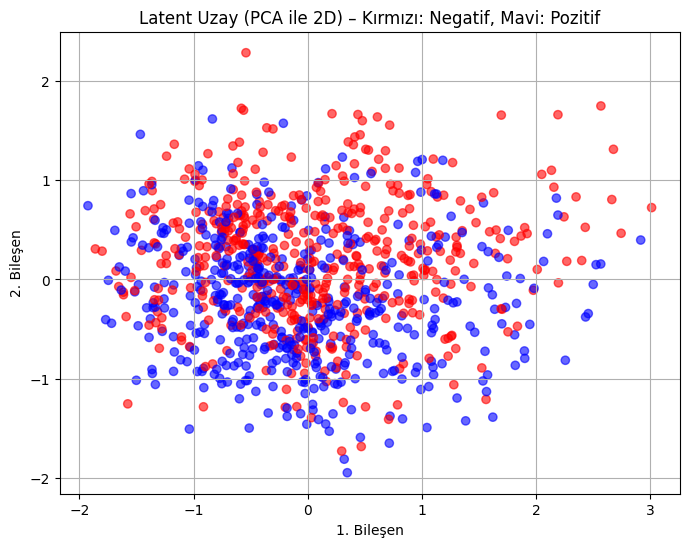

In [12]:
colors = ['red' if label == 0 else 'blue' for label in y_test_sample]

plt.figure(figsize=(8, 6))
plt.scatter(latent_2d[:, 0], latent_2d[:, 1], c=colors, alpha=0.6)
plt.title("Latent Uzay (PCA ile 2D) – Kırmızı: Negatif, Mavi: Pozitif")
plt.xlabel("1. Bileşen")
plt.ylabel("2. Bileşen")
plt.grid(True)
plt.show()


In [13]:
score = silhouette_score(latent_2d, y_test_sample)
print(f"🔍 Silhouette Skoru (etiketlere göre gruplaşma): {score:.4f}")


🔍 Silhouette Skoru (etiketlere göre gruplaşma): 0.0385


Bu soruda IMDB yorumları veri seti üzerinden yüksek boyutlu BoW temsillerini daha düşük boyutlu bir latent uzaya sıkıştırmak ve buna göre bir model kurmam istendi.

Model eğitildikten sonra test verisinde her örnek için modelin çıktıları 0.5 eşik değeriyle binarize ettim ve orijinal vektörlerle karşılaştırdım. Her bir örnek için doğru tahmin oranı hesaplandı.

📊 Ortalama doğruluk: 0.9812
📉 Standart sapma: 0.0100

Görüldüğü gibi model büyük ölçüde BoW vektörlerini başarılı bir şekilde yeniden inşa edebiliyor. Ancak burada dikkat edilmesi gereken konu, BoW vektörlerinin çoğunlukla sıfırlardan oluşması (sparse) ve dolayısıyla modelin bu sıfırları tahmin etmekte zaten avantajlı olmasıdır. Bu durum yüksek doğruluk değerine ulaşılmasında etkili olmuş olabilir. Yani her yerde sıfır olduğu için rastgele şeylere sıfır dediğinde muhtemelen başarılı olmasından dolayı böyle bir sonuç elde etmiş olabiliriz.

Reconstruction doğruluğu yüksek görünse de bu, modelin anlamlı veya semantik olarak benzer kelimeleri yeniden ürettiği anlamına gelmiyor. Model çoğu durumda en sık geçen, genel geçer kelimeleri yeniden üretiyor ve nadir kelimeleri veya yoruma özel kelimeleri ise kaçırıyor. Bu durum, modelin yorumlardaki özgün yapıyı tam olarak yakalayamadığını gösteriyor. Rekonstrüksiyon başarısı ağırlıklı olarak veri dağılımındaki baskın kelimelere dayanıyor. Yine yukarıda BoW vektörlerindeki gibi bir durum yaşanmış olabilir.

📦 Sıkıştırma Oranı
Giriş boyutu: 5000
Latent uzay boyutu: 64
Ortalama sıkıştırma oranı: 78.12

Bu oran oldukça başarılı bir sıkıştırmayı gösteriyor. Model yaklaşık 78 kat daha az boyutta bir temsille, orijinal veriye çok yakın sonuçlar üretebiliyor. Ancak yukarıda da belirttiğim gibi bu rekonstrüksiyon daha çok yapısal değil, yüzeysel başarıya işaret ediyor.

Modelin bazı test örneklerinde ürettiği vektörlere baktığımda, orijinal yorumlarda geçen özgün kelimelerin çoğunun rekonstrüksiyonda yer almadığını gördüm. Örneğin “melodrama”, “motives”, “reality”, “scenario” gibi kelimeler yerine “this”, “movie”, “it”, “is” gibi genel kelimeler öne çıkmış. Bu durum modelin semantik anlamı kaybettiğini ve yüksek doğruluğa rağmen bilgi taşıma kapasitesinin düşük olduğunu gösteriyor.

Elde ettiğim grafik incelendiğinde, pozitif (mavi) ve negatif (kırmızı) örneklerin belirgin kümeler oluşturamadığını gördüm. Bu da modelin tamamen rastgele bir biçimde tahmin yaptığını gösteriyor.  

Silhouette skoru: 0.0385
Bu skor, etiketlerin ayrışmasının çok zayıf olduğunu ortaya koyuyor.

Genel Değerlendirme
Bu ödevdeki model, yüzeyde oldukça başarılı sonuçlar veriyor gibi görünse de işin içine yorumların anlamı girdiğinde modelin performansı sınırlı kalıyor. Özellikle orijinal yorumlarda bulunan ayırt edici kelimeleri çoğunlukla kaçırması ve hep aynı genel geçer kelimeleri tahmin etmesi modelin temsil gücünü zayıflatıyor. Bu model daha çok veri sıkıştırma için uygun, ancak anlamlı temsil öğrenme için yetersiz kalıyor.